In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
import math

import nltk
import sklearn

nltk.download('stopwords')
nltk.download('punkt') 
nltk.download('vader_lexicon')

df = pd.read_csv('Customer_support_data.csv')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flame\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\flame\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\flame\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score

In [3]:
df1 = pd.read_csv('data_ML.csv')

In [4]:
df1

,category,Customer Remarks,Product_category,Item_price,Tenure Bucket,CSAT Score,remarks_length,response_time_minutes,binned_item_price,binned_response_time,binned_remarks_length
0,8,na,9,0.0,0,5,0.0,34.0,0.0,0.0,0.0
1,8,na,9,0.0,4,5,0.0,2.0,0.0,0.0,0.0
2,5,na,9,0.0,0,5,0.0,22.0,0.0,0.0,0.0
3,10,na,9,0.0,4,5,0.0,20.0,0.0,0.0,0.0
4,1,na,9,0.0,1,5,0.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
85884,9,na,9,0.0,0,4,0.0,482.0,0.0,0.0,0.0
85885,5,Supported team customer executive good,9,0.0,4,5,40.0,2.0,0.0,0.0,0.0
85886,5,need to improve with proper details.,9,0.0,0,5,36.0,5.0,0.0,0.0,0.0
85887,2,na,9,0.0,4,4,0.0,1.0,0.0,0.0,0.0


We will drop the remarks_length columns and use sentiment analysis to encode the Customer Remarks directly.

We will drop the numerical values and use their corresponding binned values.

In [5]:
df_cat = df1.drop(["Item_price","remarks_length","binned_remarks_length","response_time_minutes"],axis=1)

In [6]:
df_num = df1.drop(["binned_item_price","binned_response_time","binned_remarks_length","remarks_length"],axis=1)

In [7]:
df_cat

,category,Customer Remarks,Product_category,Tenure Bucket,CSAT Score,binned_item_price,binned_response_time
0,8,na,9,0,5,0.0,0.0
1,8,na,9,4,5,0.0,0.0
2,5,na,9,0,5,0.0,0.0
3,10,na,9,4,5,0.0,0.0
4,1,na,9,1,5,0.0,0.0
...,...,...,...,...,...,...,...
85884,9,na,9,0,4,0.0,0.0
85885,5,Supported team customer executive good,9,4,5,0.0,0.0
85886,5,need to improve with proper details.,9,0,5,0.0,0.0
85887,2,na,9,4,4,0.0,0.0


In [9]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Remove noise from text (e.g., punctuation, special characters)
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.lower()  # Convert text to lowercase
    return text

# Tokenize text (split into individual words or tokens)
def tokenize_text(text):
    return word_tokenize(text)

# Remove stopwords from text (common words that don't carry much meaning)
stop_words = set(stopwords.words('english'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Perform stemming (reduce words to their base forms)
stemmer = PorterStemmer()

def stem_text(tokens):
    return [stemmer.stem(word) for word in tokens]

# Apply preprocessing functions to your DataFrame
df_cat['clean_comment'] = df_cat['Customer Remarks'].apply(clean_text)
df_cat['tokens'] = df_cat['clean_comment'].apply(tokenize_text)
df_cat['tokens'] = df_cat['tokens'].apply(remove_stopwords)
df_cat['stemmed_tokens'] = df_cat['tokens'].apply(stem_text)

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Analyze sentiment of each customer comment
df_cat['sentiment'] = df_cat['Customer Remarks'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [11]:
# Transform CSAT Score into classes
def categorize_satisfaction(score):
    if score >= 4:
        return 'High Satisfaction'
    else:
        return 'Low Satisfaction'

df_cat['satisfaction_class'] = df_cat['CSAT Score'].apply(categorize_satisfaction)

In [12]:
df_cat

,category,Customer Remarks,Product_category,Tenure Bucket,CSAT Score,binned_item_price,binned_response_time,clean_comment,tokens,stemmed_tokens,sentiment,satisfaction_class
0,8,na,9,0,5,0.0,0.0,na,[na],[na],0.0000,High Satisfaction
1,8,na,9,4,5,0.0,0.0,na,[na],[na],0.0000,High Satisfaction
2,5,na,9,0,5,0.0,0.0,na,[na],[na],0.0000,High Satisfaction
3,10,na,9,4,5,0.0,0.0,na,[na],[na],0.0000,High Satisfaction
4,1,na,9,1,5,0.0,0.0,na,[na],[na],0.0000,High Satisfaction
...,...,...,...,...,...,...,...,...,...,...,...,...
85884,9,na,9,0,4,0.0,0.0,na,[na],[na],0.0000,High Satisfaction
85885,5,Supported team customer executive good,9,4,5,0.0,0.0,supported team customer executive good,"[supported, team, customer, executive, good]","[support, team, custom, execut, good]",0.6369,High Satisfaction
85886,5,need to improve with proper details.,9,0,5,0.0,0.0,need to improve with proper details,"[need, improve, proper, details]","[need, improv, proper, detail]",0.4404,High Satisfaction
85887,2,na,9,4,4,0.0,0.0,na,[na],[na],0.0000,High Satisfaction


In [13]:
y = pd.DataFrame(df_cat["satisfaction_class"])
x = pd.DataFrame(df_cat["sentiment"])

In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=69)

# Initialize and train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=69)
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the model using classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
                   precision    recall  f1-score   support

High Satisfaction       0.85      0.99      0.91     14209
 Low Satisfaction       0.72      0.17      0.27      2969

         accuracy                           0.84     17178
        macro avg       0.78      0.58      0.59     17178
     weighted avg       0.83      0.84      0.80     17178

Accuracy: 0.8449179182675515


In [16]:
y = pd.DataFrame(df_cat["satisfaction_class"])
x = pd.DataFrame(df_cat.drop(["satisfaction_class","clean_comment","tokens","stemmed_tokens","Customer Remarks","CSAT Score"],axis=1))

In [17]:
x

,category,Product_category,Tenure Bucket,binned_item_price,binned_response_time,sentiment
0,8,9,0,0.0,0.0,0.0000
1,8,9,4,0.0,0.0,0.0000
2,5,9,0,0.0,0.0,0.0000
3,10,9,4,0.0,0.0,0.0000
4,1,9,1,0.0,0.0,0.0000
...,...,...,...,...,...,...
85884,9,9,0,0.0,0.0,0.0000
85885,5,9,4,0.0,0.0,0.6369
85886,5,9,0,0.0,0.0,0.4404
85887,2,9,4,0.0,0.0,0.0000


In [18]:
y

,satisfaction_class
0,High Satisfaction
1,High Satisfaction
2,High Satisfaction
3,High Satisfaction
4,High Satisfaction
...,...
85884,High Satisfaction
85885,High Satisfaction
85886,High Satisfaction
85887,High Satisfaction


In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Initialize and train a Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(x_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(x_test)

# Evaluate the model using classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
                   precision    recall  f1-score   support

High Satisfaction       0.86      0.98      0.91     14240
 Low Satisfaction       0.69      0.20      0.31      2938

         accuracy                           0.85     17178
        macro avg       0.77      0.59      0.61     17178
     weighted avg       0.83      0.85      0.81     17178

Accuracy: 0.8476539760158343


In [20]:
clf.score(x_test, y_test)

0.8476539760158343

[Text(0.5, 0.9166666666666666, 'sentiment <= -0.028\ngini = 0.291\nsamples = 68711\nvalue = [56584, 12127]\nclass = Bad'),
 Text(0.25, 0.75, 'sentiment <= -0.402\ngini = 0.444\nsamples = 3843\nvalue = [1276, 2567]\nclass = Good'),
 Text(0.125, 0.5833333333333334, 'Product_category <= 8.5\ngini = 0.338\nsamples = 2126\nvalue = [458, 1668]\nclass = Good'),
 Text(0.0625, 0.4166666666666667, 'Tenure Bucket <= 0.5\ngini = 0.219\nsamples = 607\nvalue = [76, 531]\nclass = Good'),
 Text(0.03125, 0.25, 'binned_response_time <= 0.5\ngini = 0.114\nsamples = 182\nvalue = [11, 171]\nclass = Good'),
 Text(0.015625, 0.08333333333333333, 'gini = 0.152\nsamples = 133\nvalue = [11, 122]\nclass = Good'),
 Text(0.046875, 0.08333333333333333, 'gini = 0.0\nsamples = 49\nvalue = [0, 49]\nclass = Good'),
 Text(0.09375, 0.25, 'Product_category <= 2.5\ngini = 0.259\nsamples = 425\nvalue = [65, 360]\nclass = Good'),
 Text(0.078125, 0.08333333333333333, 'gini = 0.353\nsamples = 166\nvalue = [38, 128]\nclass = Goo

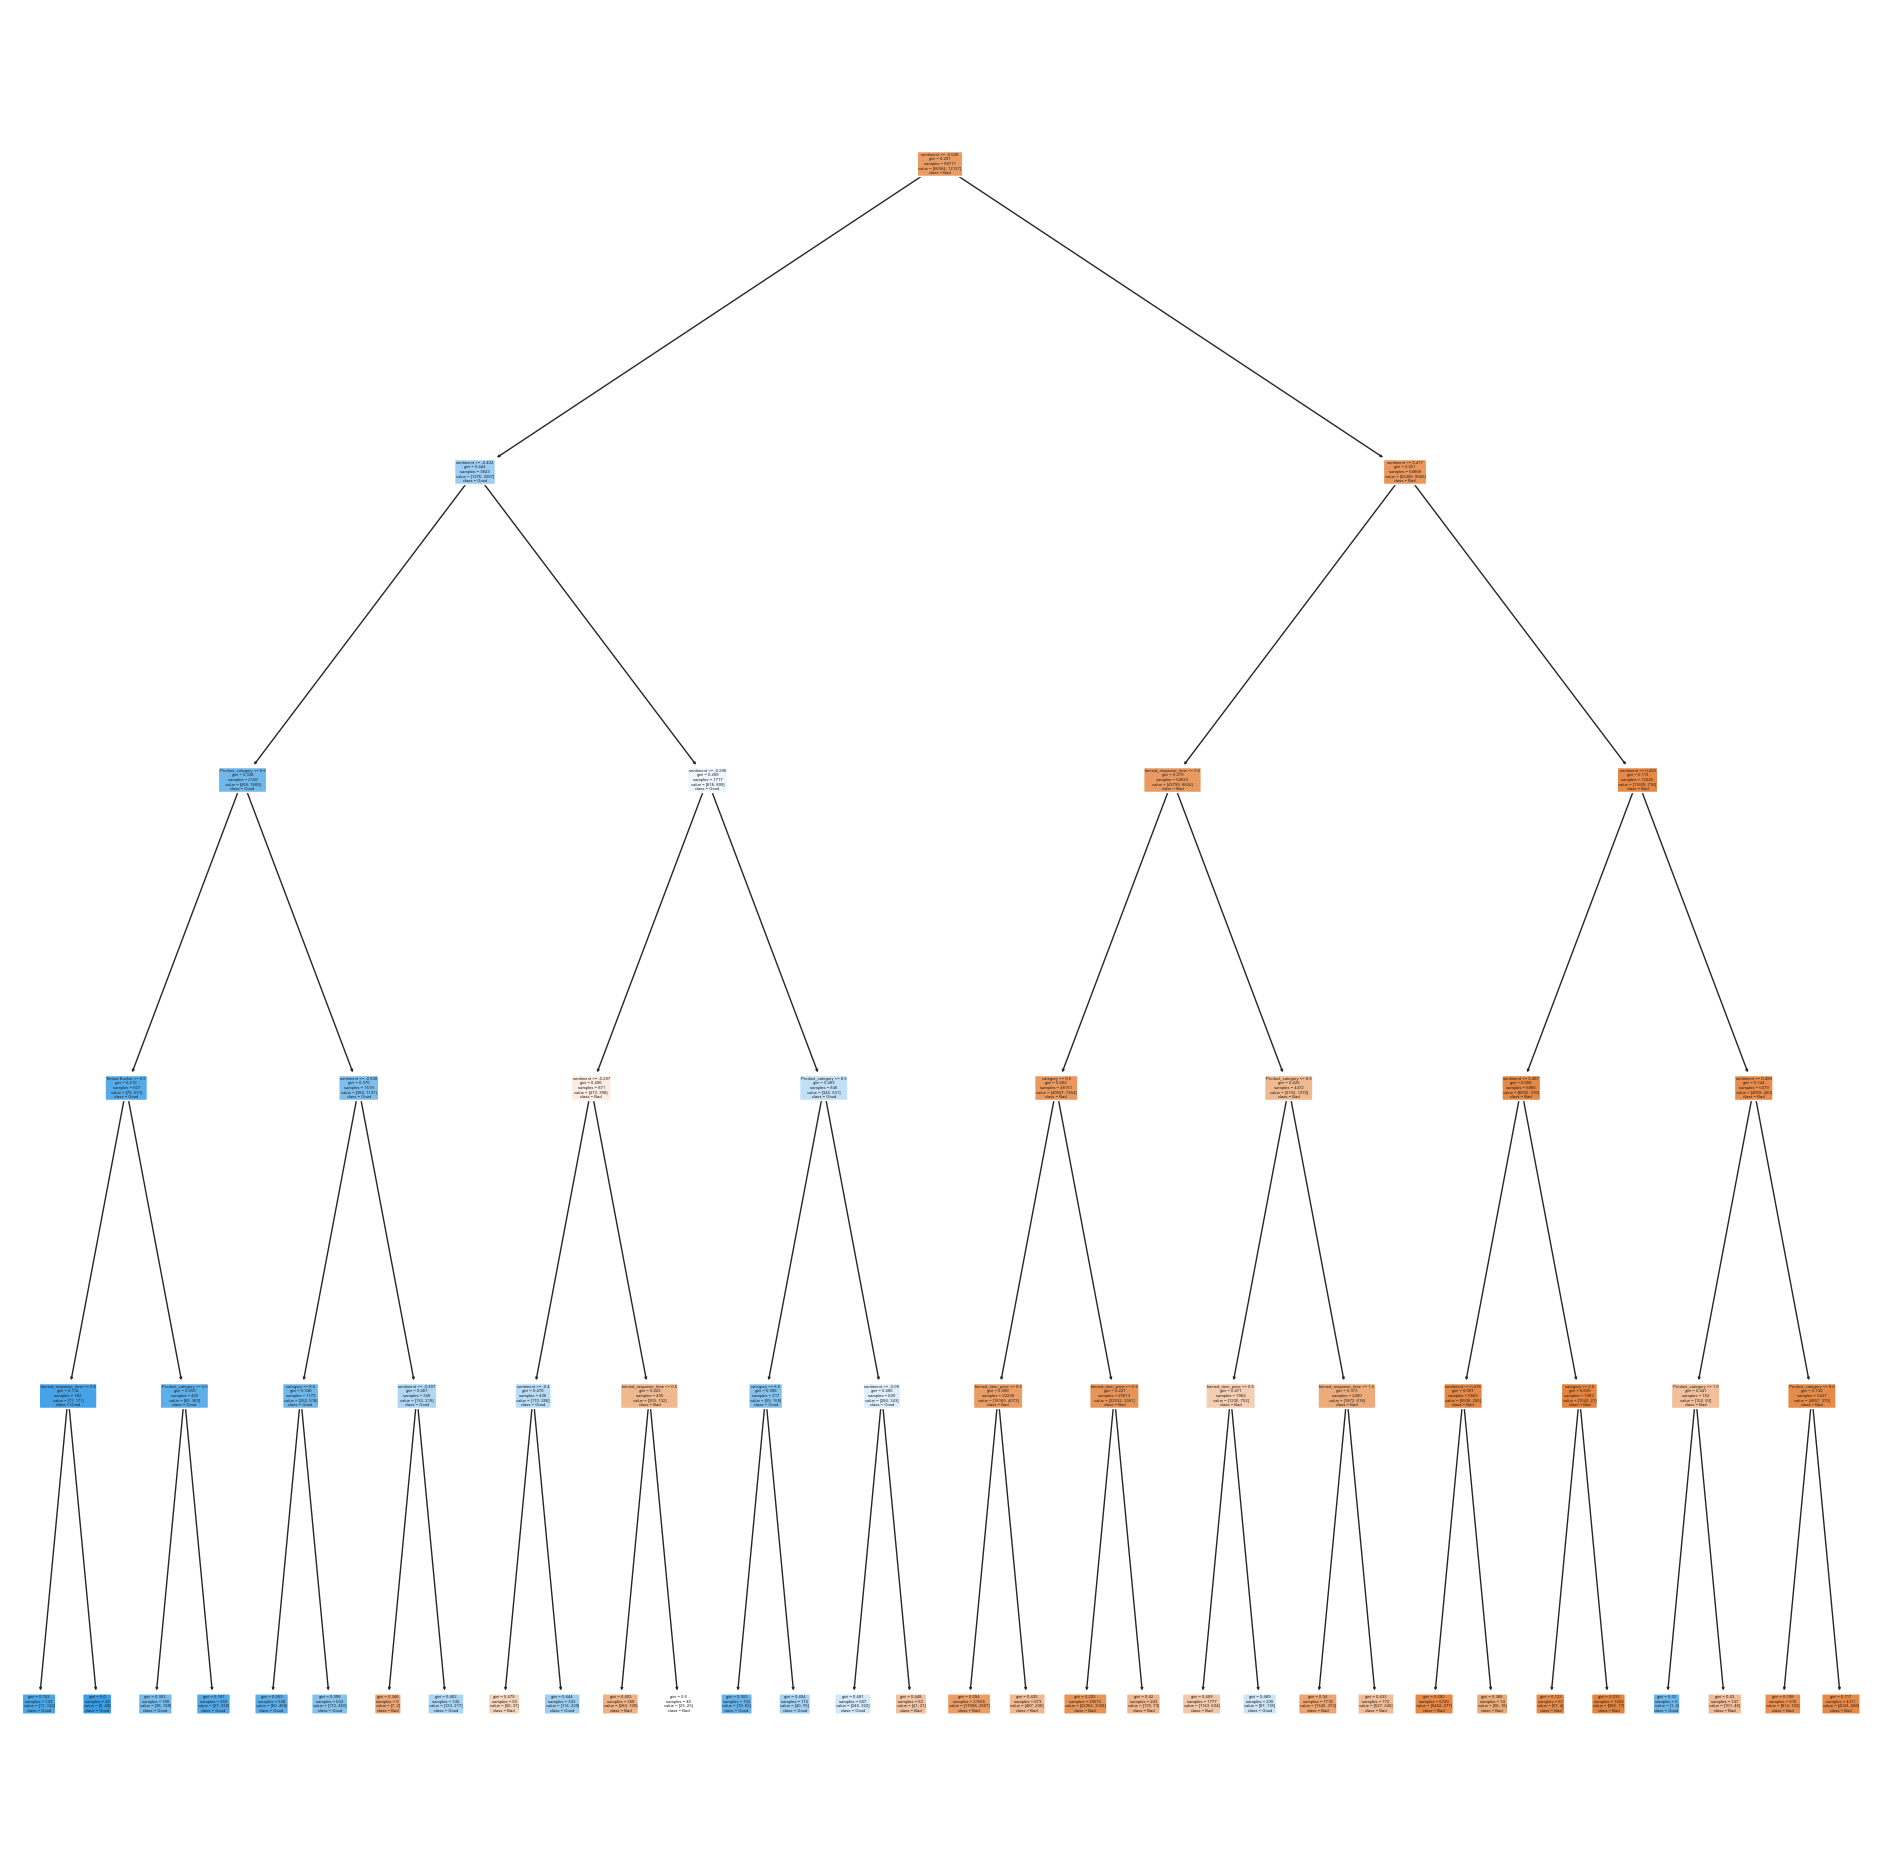

In [21]:
f=plt.figure(figsize=(24,24))
plot_tree(clf,filled=True, rounded =True, feature_names = x_train.columns, class_names = ["Bad","Good"])

Prediction on Test Data
Prediction Accuracy  : 0.8476539760158343

True Positive Rate : 0.1980939414567733
True Negative Rate : 0.9816713483146068

False Positive Rate : 0.018328651685393257
False Negative Rate : 0.8019060585432267


<AxesSubplot:>

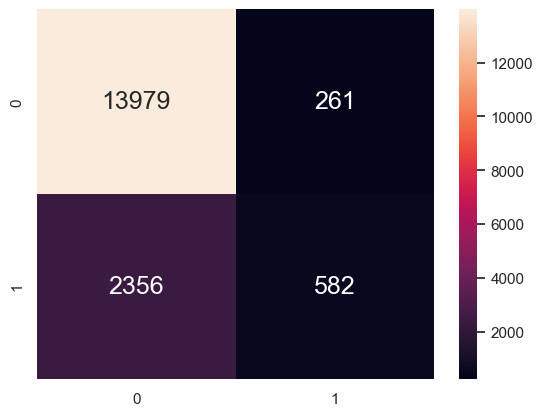

In [22]:

print("Prediction on Test Data")
print("Prediction Accuracy  :", clf.score(x_test, y_test))
print()

con_mat_test = confusion_matrix(y_test, y_pred)
tpTest = con_mat_test[1][1] # True Positives: Good predicted as good 
fpTest = con_mat_test[0][1] # False Positives: Bad predicted as good 
tnTest = con_mat_test[0][0] # True Negatives: Bad predicted as bad 
fnTest = con_mat_test[1][0] # False Negatives: Good predicted as bad 

print("True Positive Rate :", (tpTest/(tpTest + fnTest)))
print("True Negative Rate :", (tnTest/(tnTest + fpTest)))
print()

print("False Positive Rate :", (fpTest/(fpTest + tnTest)))
print("False Negative Rate :", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

In [23]:
y = pd.DataFrame(df_cat["satisfaction_class"])
x = pd.DataFrame(df_cat.drop(["satisfaction_class","clean_comment","tokens","stemmed_tokens","Customer Remarks","CSAT Score"],axis=1))

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2)

randForest = RandomForestClassifier(n_estimators = 1000, max_depth = 10)

randForest.fit(x_train,y_train.satisfaction_class.ravel())


RandomForestClassifier(max_depth=10, n_estimators=1000)

Prediction on Test Data
Prediction Accuracy  : 0.8418907905460473

True Positive Rate:  0.18702915165411071
True Negative Rate:  0.983433628318584

False Positie Rate:  0.01656637168141593
False Negative Rate:  0.8129708483458893


<AxesSubplot:>

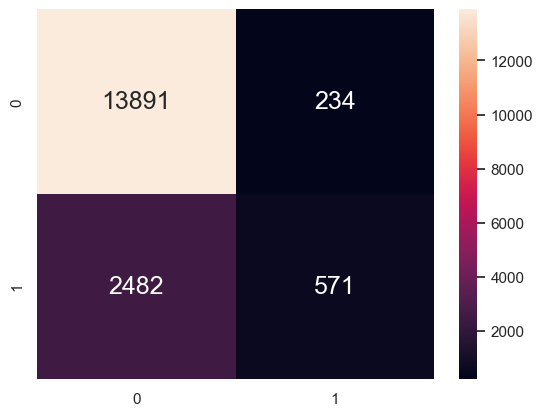

In [24]:
y_test_pred = randForest.predict(x_test)

print("Prediction on Test Data")
print("Prediction Accuracy  :", randForest.score(x_test, y_test))
print()

con_mat_test = confusion_matrix(y_test, y_test_pred)
tpTest = con_mat_test[1][1] # True Positives: Good predicted as good 
fpTest = con_mat_test[0][1] # False Positives: Bad predicted as good 
tnTest = con_mat_test[0][0] # True Negatives: Bad predicted as bad 
fnTest = con_mat_test[1][0] # False Negatives: Good predicted as bad 

print("True Positive Rate: ", (tpTest/(tpTest + fnTest)))
print("True Negative Rate: ", (tnTest/(tnTest + fpTest)))
print()

print("False Positie Rate: ", (fpTest/(fpTest + tnTest)))
print("False Negative Rate: ", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(con_mat_test, annot = True, fmt=".0f", annot_kws={"size": 18})

In [25]:
param_grid = {"n_estimators": np.arange(100,1001,100),
             "max_depth":np.arange(2,11)}

hyper_grid = GridSearchCV(RandomForestClassifier(),
                        param_grid,
                        cv = 5,
                        scoring = "accuracy")

hyper_grid.fit(x_train,y_train.satisfaction_class.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
             scoring='accuracy')

In [26]:
hyper_grid.best_estimator_

RandomForestClassifier(max_depth=9, n_estimators=500)

In [27]:

hyper_grid.best_score_

0.8467785523666865

Repeat the random forrest classification with parameters: max_depth = 9, n_estimators=500
The resulting model have a high accuracy but has low true positive rate.

Prediction on Test Data
Prediction Accuracy  : 0.8448597042729072

True Positive Rate:  0.19980347199475926
True Negative Rate:  0.984283185840708

False Positie Rate:  0.015716814159292037
False Negative Rate:  0.8001965280052408


<AxesSubplot:>

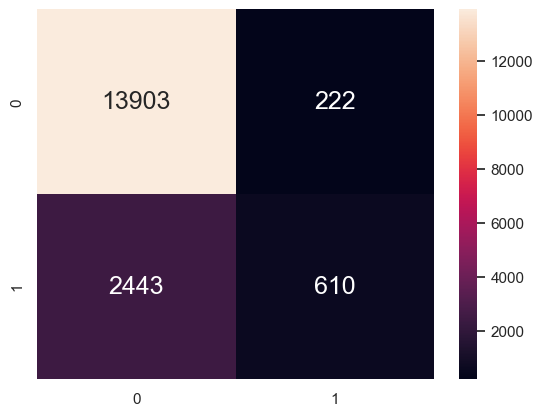

In [28]:
y = pd.DataFrame(df_cat["satisfaction_class"])
x = pd.DataFrame(df_cat.drop(["satisfaction_class","clean_comment","tokens","stemmed_tokens","Customer Remarks","CSAT Score"],axis=1))

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2)

randForest = RandomForestClassifier(n_estimators = 500, max_depth = 9)

randForest.fit(x_train,y_train.satisfaction_class.ravel())

y_test_pred = randForest.predict(x_test)

print("Prediction on Test Data")
print("Prediction Accuracy  :", randForest.score(x_test, y_test))
print()

con_mat_test = confusion_matrix(y_test, y_test_pred)
tpTest = con_mat_test[1][1] # True Positives: Good predicted as good 
fpTest = con_mat_test[0][1] # False Positives: Bad predicted as good 
tnTest = con_mat_test[0][0] # True Negatives: Bad predicted as bad 
fnTest = con_mat_test[1][0] # False Negatives: Good predicted as bad 

print("True Positive Rate: ", (tpTest/(tpTest + fnTest)))
print("True Negative Rate: ", (tnTest/(tnTest + fpTest)))
print()

print("False Positie Rate: ", (fpTest/(fpTest + tnTest)))
print("False Negative Rate: ", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(con_mat_test, annot = True, fmt=".0f", annot_kws={"size": 18})